In [17]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import glob
import tminlib.colorlevel as cl
from tminlib import plot_helper as phelp
import os
from datetime import datetime, timedelta
from skimage.morphology import skeletonize, dilation, disk
import matplotlib.dates as mdates

VM=cl.VarMap()
varname_table=VM.varname_table
varunit_table=VM.varunit_table
config = configparser.ConfigParser()
config.read("./NFGDA.ini")
export_preds_dir = config["Settings"]["export_preds_dir"]
evalbox_on = config.getboolean('Settings', 'evalbox_on')
fig_dir = config["Settings"]["fig_dir"]

In [18]:
clist=['KABX20200704_02',
'KABX20200705_21',
'KABX20200707_01',
'KABX20200712_21',
'KABX20200715_23',
'KABX20200721_03',
'KABX20200721_19',
'KABX20200724_21',
'KABX20200726_19',
'KABX20210702_21',
'KABX20210704_00',
'KABX20210705_05',
'KABX20210706_00',
'KABX20210706_23',
'KABX20210707_01',
'KABX20210709_22']

In [29]:
data = np.load(export_preds_dir+'KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz')
data.files

['xi2', 'yi2', 'REF', 'nfout', 'inputNF', 'evalbox']

8.135593220338983
236


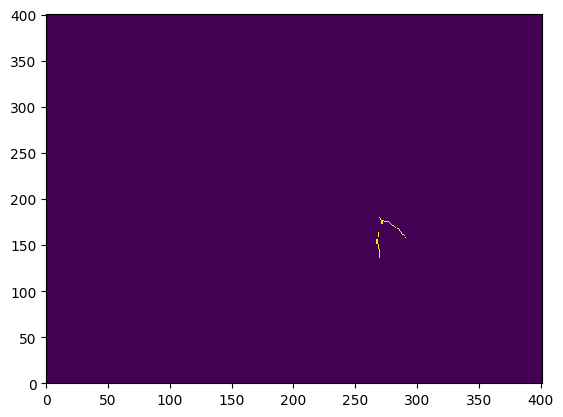

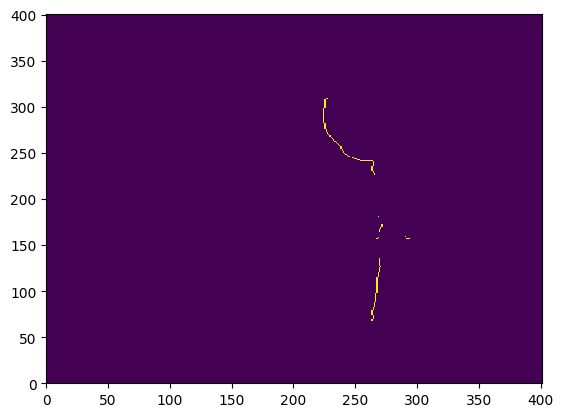

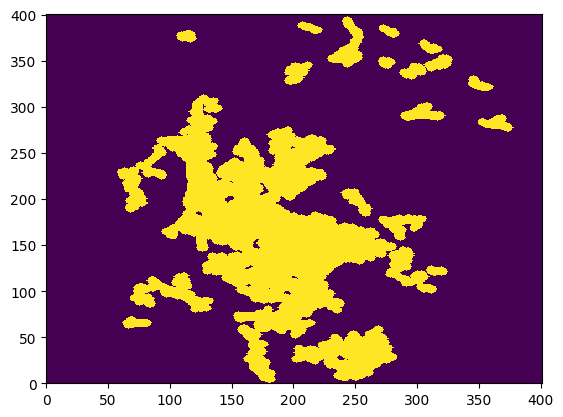

In [65]:
from skimage.morphology import skeletonize, dilation, disk
skeleton = skeletonize(data['evalbox'])
length = np.sum(skeleton)
avg_width = np.sum(data['evalbox'])/length
print(avg_width)
print(length)

r = np.sqrt(Cx**2+Cy**2)
mask = r>=100
nfloc = np.logical_and(~mask,nfout)
hits = np.logical_and(skeleton,dilation(nfout, disk(4)))
miss = np.logical_and(skeleton,~dilation(nfout, disk(4)))
plt.pcolormesh(hits)
plt.figure()
plt.pcolormesh(miss)


In [113]:
def case_proc(case_name):
    exp_preds_event = export_preds_dir + case_name
    savedir = os.path.join(fig_dir, case_name)
    os.makedirs(savedir,exist_ok=True)
    npz_list = glob.glob(exp_preds_event + "/*npz")
    hits = []
    miss = []
    false_alarm = []
    total_nf_points = []
    tvec=[]
    for ppi_file in npz_list:
        print(ppi_file)
        ppi_id = os.path.basename(ppi_file)
        data = np.load(ppi_file)
        Cx = data['xi2']
        Cy = data['yi2']
        # REF = data['REF']
        REF = data['inputNF'][:,:,1]    
        nfout = data['nfout']
        evalbox = data['evalbox']
        r = np.sqrt(Cx**2+Cy**2)
        mask = r>=100
        nfloc = np.logical_and(~mask,nfout)
        
        evalline = skeletonize(data['evalbox'])
        nfpredict = dilation(nfloc, disk(5))
        Mhits = np.logical_and(evalline,nfpredict)
        Mmiss = np.logical_and(evalline,~nfpredict)
        # nfloc = skeletonize(nfpredict)
        
        hits.append(np.sum(Mhits))
        miss.append(np.sum(Mmiss))
        false_alarm.append(np.sum(np.logical_and(np.logical_not(evalbox),nfloc)))
        total_nf_points.append(np.sum(nfloc))
        
        ppi_name = ppi_id[11:]  # MATLAB 12:end is Python 11: (0-based)
        date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
        time_part = ppi_name[13:19]  # 14:19 in MATLAB → 13:19 in Python
        
        # Parse date and time
        tstamp_date = datetime.strptime(date_part, "%Y%m%d")
        tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
        tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
        tvec.append(tstamp)
        # Extract radar ID
        radar_id = ppi_name[0:4]  # 1:4 in MATLAB → 0:4 in Python
        
        # Format description string
        ppi_desc = f"{radar_id}, {tstamp.strftime('%m/%d/%Y, %H:%M:%S %Z')}"
        fig, axs = plt.subplots(1, 1, figsize=(3/0.7, 2.5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
        pdata = np.ma.masked_where(mask,REF)
        plt.pcolormesh(Cx,Cy,pdata,cmap=cl.zmap,norm=cl.znorm)
        plt.plot(Cx[nfloc],Cy[nfloc],'k.',markersize=0.8)
        plt.plot(Cx[np.logical_and(nfloc,evalbox)],Cy[np.logical_and(nfloc,evalbox)],'r.',markersize=0.8)
        plt.plot(Cx[Mmiss],Cy[Mmiss],'b.',markersize=0.8)
        plt.plot(Cx[Mhits],Cy[Mhits],'.',color=(0,1,0),markersize=0.8)
        plt.contour(Cx,Cy,evalbox,[0.5], colors='y',linewidths=0.8)
        plt.text(0.025, 0.975,  f'PLD = {100*hits[-1]/(hits[-1]+miss[-1]):.2f}%\nPLF = {100*false_alarm[-1]/np.sum(nfloc):.2f}%', 
                 transform=plt.gca().transAxes, verticalalignment='top', fontsize=7)
        plt.title(ppi_desc)
        plt.axis('equal')
        phelp.add_cbar(axs.collections[0],fig,axs,unit_text = varunit_table['Zh'],size='3%')
        # evalzone='../../V06/KAMA20240227_21/KAMA20240227_21_labels/'+ppi_id[11:-3]+'mat'
        # if os.path.exists(evalzone):
        #     print('load '+evalzone)
        #     a=scipy.io.loadmat(evalzone)
        #     mask = a['handpick']==1
        #     axs.plot(Cx[mask].reshape(-1),Cy[mask].reshape(-1),'y.')

        fig.savefig(os.path.join(savedir, ppi_id[:-4]+'.png'))
        plt.close(fig)
    hits = np.array(hits)
    miss = np.array(miss)
    false_alarm = np.array(false_alarm)
    total_nf_points = np.array(total_nf_points)
    plt.plot(tvec,1e2*hits/(miss+hits),color='r',label=f'Mean Hit Rate = {np.nanmean(hits/(miss+hits))*100:.2f}%')
    # plt.plot(1e2*miss/(miss+hits),color='g',label=f'Mean Miss Rate = {np.nanmean(miss/(miss+hits))*100:.2f}%')
    plt.plot(tvec,1e2*false_alarm/(total_nf_points),color='b',label=f'Mean False Alarm Rate= {np.nanmean(false_alarm/(total_nf_points))*100:.2f}%')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.title(case_name)
    # plt.xlabel('Time (Frame)')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.savefig(os.path.join(savedir, 'statistics.png'))
    plt.close()


In [115]:
for case_name in clist:
    print(case_name)
    case_proc(case_name)

KABX20200704_02
./tracking_points/nf_preds/KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_04_KABX20200704_023622_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_05_KABX20200704_024300_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_06_KABX20200704_024922_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_07_KABX20200704_025724_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_08_KABX20200704_030346_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_09_KABX20200704_031036_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_10_KABX20200704_031714_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_11_KABX20200704_032421_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_12_KABX20200704_033128_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz


/tmp/ipykernel_889/3566098857.py:58: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(0.025, 0.975,  f'PLD = {100*hits[-1]/(hits[-1]+miss[-1]):.2f}%\nPLF = {100*false_alarm[-1]/np.sum(nfloc):.2f}%',


./tracking_points/nf_preds/KABX20200712_21/nf_pred_10_KABX20200712_222333_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_11_KABX20200712_223003_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_12_KABX20200712_223628_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_13_KABX20200712_224244_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_14_KABX20200712_224900_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_15_KABX20200712_225509_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_16_KABX20200712_230119_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_17_KABX20200712_230714_V06.npz
./tracking_points/nf_preds/KABX20200712_21/nf_pred_18_KABX20200712_231314_V06.npz


/tmp/ipykernel_889/3566098857.py:76: RuntimeWarning: invalid value encountered in divide
  plt.plot(tvec,1e2*hits/(miss+hits),color='r',label=f'Mean Hit Rate = {np.nanmean(hits/(miss+hits))*100:.2f}%')


KABX20200715_23
./tracking_points/nf_preds/KABX20200715_23/nf_pred_02_KABX20200715_232706_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_03_KABX20200715_233358_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_04_KABX20200715_234056_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_05_KABX20200715_234804_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_06_KABX20200715_235512_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_07_KABX20200716_000152_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_08_KABX20200716_000833_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_09_KABX20200716_001513_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_10_KABX20200716_002154_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_11_KABX20200716_002833_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_12_KABX20200716_003513_V06.npz
./tracking_points/nf_preds/KABX20200715_23/nf_pred_13_KABX20200716_004154_V06.npz


In [16]:
import scipy.io
for ppi_file in npz_list:
    ppi_id = os.path.basename(ppi_file)
    evalzone='../../V06/KAMA20240227_21/KAMA20240227_21_labels/'+ppi_id[11:-3]+'mat'
    if os.path.exists(evalzone):
        a=scipy.io.loadmat(evalzone)
        mask=a['handpick']==1
        plt.plot(Cx[mask].reshape(-1),Cy[mask].reshape(-1),'y.')

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_02_KAMA20240227_213943_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_03_KAMA20240227_214919_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_04_KAMA20240227_215858_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_05_KAMA20240227_220835_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_06_KAMA20240227_221813_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_07_KAMA20240227_222751_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_08_KAMA20240227_223728_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_09_KAMA20240227_224706_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_10_KAMA20240227_225645_V06.npz
File exists!

.././tracking_points/nf_preds/KAMA20240227_21/nf_pred_11_KAMA20240227_230623_V06.npz
File exists!

.././track

In [4]:
input_label=[r'$\beta$',
            r'$Z$',
            r'$\rho_{hv}$',
            r'$Z_{DR}$',
            r'$\sigma_{V}$',
            r'$\Phi_{DP}$']

In [5]:
os.makedirs(os.path.join(savedir, 'hist'),exist_ok=True)

In [14]:
for ppi_file in npz_list:
    print(ppi_file)
    ppi_id = os.path.basename(ppi_file)
    data = np.load(ppi_file)
    Cx = data['xi2']
    Cy = data['yi2']
    # REF = data['REF']
    REF = data['inputNF'][:,:,1]    
    nfout = data['nfout']
    r = np.sqrt(Cx**2+Cy**2)
    mask = r>=100
    
    ppi_name = ppi_id[11:]  # MATLAB 12:end is Python 11: (0-based)
    date_part = ppi_name[4:12]   # 5:12 in MATLAB → 4:12 in Python
    time_part = ppi_name[13:19]  # 14:19 in MATLAB → 13:19 in Python
    
    # Parse date and time
    tstamp_date = datetime.strptime(date_part, "%Y%m%d")
    tstamp_time = datetime.strptime(time_part, "%H%M%S").time()
    tstamp = datetime.combine(tstamp_date.date(), tstamp_time)
    
    # Extract radar ID
    radar_id = ppi_name[0:4]  # 1:4 in MATLAB → 0:4 in Python
    
    # Format description string
    ppi_desc = f"{radar_id}, {tstamp.strftime('%m/%d/%Y, %H:%M:%S %Z')}"

    nfpoints = np.logical_and(~mask,nfout)
    
    evalzone='../../V06/KAMA20240227_21/KAMA20240227_21_labels/'+ppi_id[11:-3]+'mat'
    if os.path.exists(evalzone):
        print('load '+evalzone)
        a=scipy.io.loadmat(evalzone)
        gfpoints = a['handpick']==1
        # axs.plot(Cx[gfpoints].reshape(-1),Cy[gfpoints].reshape(-1),'y.')
    
        fig, axs = plt.subplots(2, 3, figsize=(9/0.7, 5/0.7),dpi=250, gridspec_kw=dict(left=0.08, right=1-0.085, top=1-0.08, bottom=0.06, wspace=0.25, hspace=0.16))
    
        for idx in range(6):
            pdata = data['inputNF'][:,:,idx]
            mdata = pdata[gfpoints]
            mdata = mdata[~np.isnan(mdata)]
            if mdata.size==0:
                continue
            ia = np.unravel_index(idx,(2,3))
            counts, bins, patches = axs[ia].hist(pdata[nfpoints], bins=25, alpha=0.7, density=True)
            axs[ia].hist(mdata, bins=int(np.ceil(25*np.max([np.ptp(mdata),0.001])/np.ptp(pdata[nfpoints]))), alpha=0.7, density=True)
            phelp.corner_title(axs[ia],input_label[idx], 0.965, 0.965)
            axs[ia].set_ylim(0,np.max(counts)*1.1)
        # plt.title(ppi_desc+input_label[nfidx])
        plt.suptitle(ppi_desc)
        axs[0,1].legend(['NFGDA','Truth'],loc='upper left')
        
        fig.savefig(os.path.join(savedir,'hist',ppi_id[:-4]+'.png'))
        
        plt.close(fig)
    

./tracking_points/nf_preds/KABX20200704_02/nf_pred_02_KABX20200704_022322_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_03_KABX20200704_022945_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_04_KABX20200704_023622_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_05_KABX20200704_024300_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_06_KABX20200704_024922_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_07_KABX20200704_025724_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_08_KABX20200704_030346_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_09_KABX20200704_031036_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_10_KABX20200704_031714_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_11_KABX20200704_032421_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_12_KABX20200704_033128_V06.npz
./tracking_points/nf_preds/KABX20200704_02/nf_pred_13_KABX20200704_033835_V06.npz
./tracking_point

In [71]:
np.ptp(pdata[nfpoints])

0.4318431633975294

In [114]:
def get_df(S1,S2,dt):
    f1=np.fft.fft2(S1)
    f2=np.fft.fft2(S2)
    da = np.abs(f2)-np.abs(f1)
    dphi = np.angle(f2)-np.angle(f1)
    At = np.sum(np.abs(f2))
    A = np.abs(f2) + da*dt
    A[A<0] = 0
    A = A*At/np.sum(np.abs(A))
    A = np.abs(f2)
    return np.real(np.fft.ifft2(A*np.exp(1j*(np.angle(f2)+dphi*dt))))

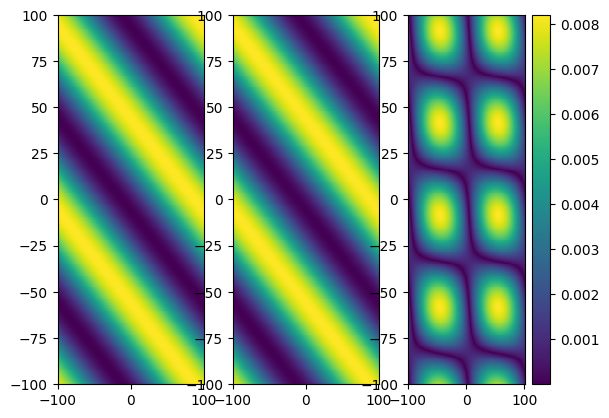

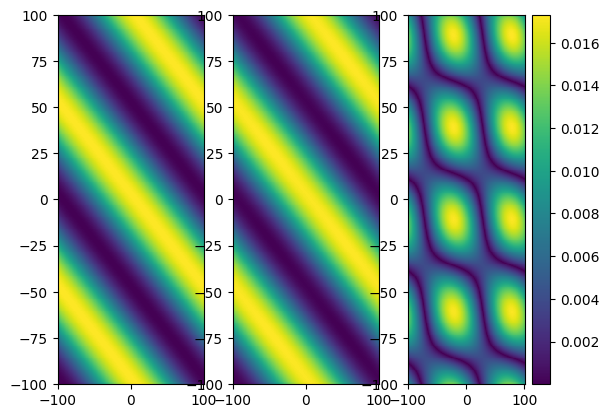

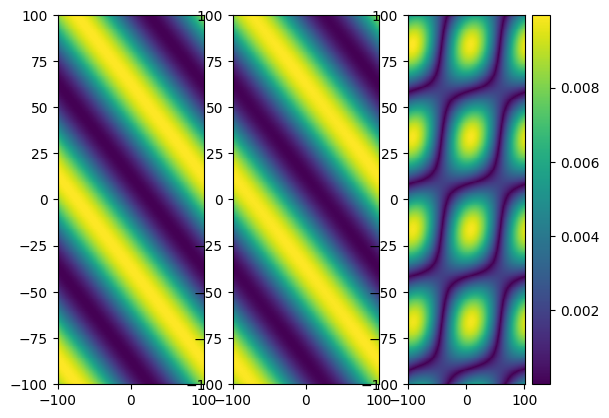

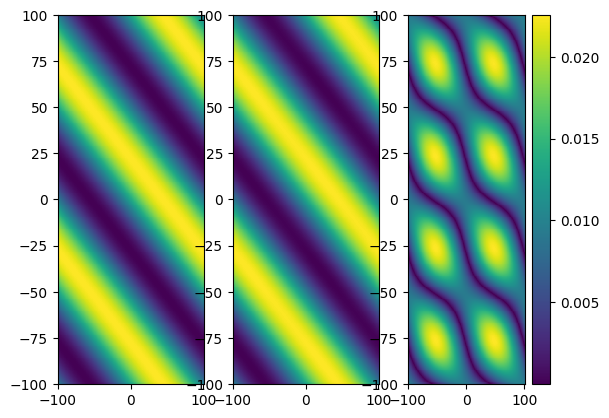

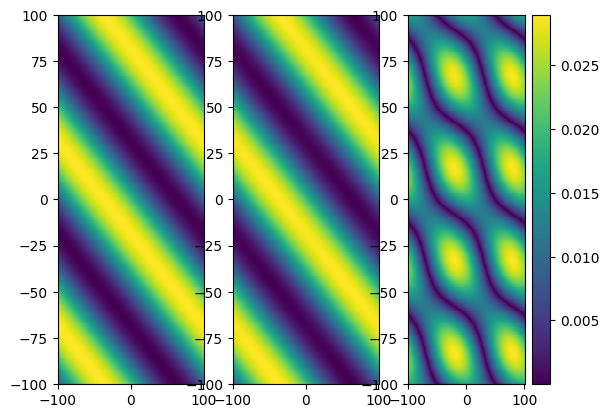

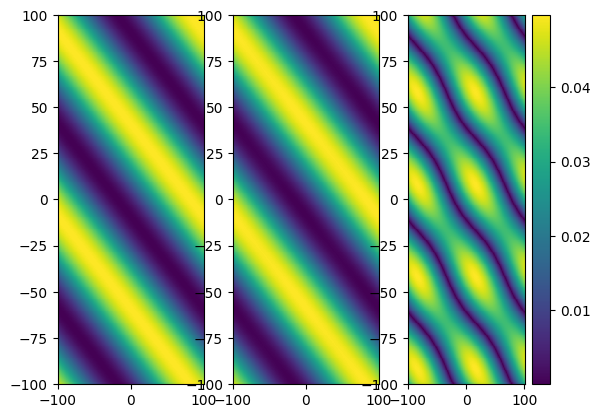

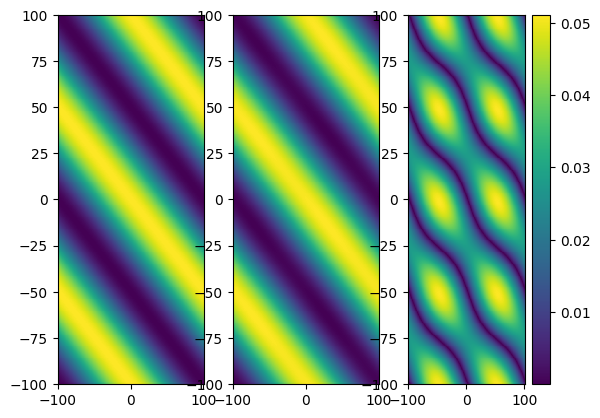

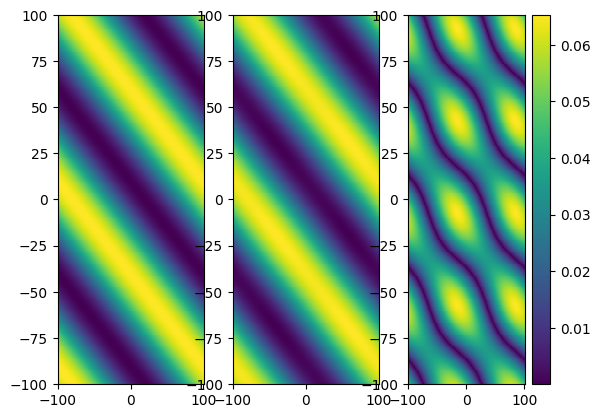

In [99]:
fx=1
fy=2
vx=21
vy=30
dv = 0.1
S=[]
for t in range(2):
    S.append(np.sin(2*np.pi*(fx/np.ptp(Cx)*(Cx+vx*t)+fy/np.ptp(Cy)*(Cy+vy*t))))
# P.append(S[0])
# P.append(S[1])
for t in range(2,10):
    vx=21 + np.random.random(1)*dv
    vy=30 + np.random.random(1)*dv
    fig,ax=plt.subplots(1,3)
    a=np.sin(2*np.pi*(fx/np.ptp(Cx)*(Cx+vx*t)+fy/np.ptp(Cy)*(Cy+vy*t)))
    ax[0].pcolormesh(Cx,Cy,a)
    b=get_df(S[0],S[1],t-1)
    ax[1].pcolormesh(Cx,Cy,b)
    pc=ax[2].pcolormesh(Cx,Cy,np.abs(b-a))
    fig.colorbar(pc)
    

In [90]:
def predict_next_wave_frame(eta_t1, eta_t2, dt):
    """
    Estimate wave speed from two frames and predict the next frame using spectral method.

    Parameters:
        eta_t1: 2D array, wave height at time t1
        eta_t2: 2D array, wave height at time t2
        dt: float, time difference between the two frames
        g: float, gravity constant (default 9.81 m/s^2)

    Returns:
        eta_t3: 2D array, predicted wave height at time t3 = t2 + dt
        c_est: float, estimated phase speed
    """
    N, M = eta_t1.shape
    dx = dy = 1.0  # assume unit grid spacing (can parameterize if needed)

    # Fourier transform of both frames
    fft_t1 = np.fft.fft2(eta_t1)
    fft_t2 = np.fft.fft2(eta_t2)

    # Compute phase difference
    phase_t1 = np.angle(fft_t1)
    phase_t2 = np.angle(fft_t2)
    delta_phase = phase_t2 - phase_t1

    # Wavenumber grids
    kx = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(M, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K = np.sqrt(KX**2 + KY**2)
    
    # Avoid zero frequency (DC)
    K[0,0] = np.nan

    # Estimate angular frequency ω from phase shift
    omega = delta_phase / dt

    # Estimate phase speed c = ω / k for the dominant wave number
    power_spectrum = np.abs(fft_t1)**2
    power_spectrum[0,0] = 0  # ignore DC

    dominant_idx = np.unravel_index(np.argmax(power_spectrum), power_spectrum.shape)
    k_dom = K[dominant_idx]
    omega_dom = omega[dominant_idx]
    c_est = np.abs(omega_dom / k_dom)

    # Predict next frame in Fourier domain using phase evolution
    fft_t3 = fft_t2 * np.exp(1j * (omega * dt))

    # Inverse FFT to get back to spatial domain
    eta_t3 = np.real(np.fft.ifft2(fft_t3))

    return eta_t3, c_est

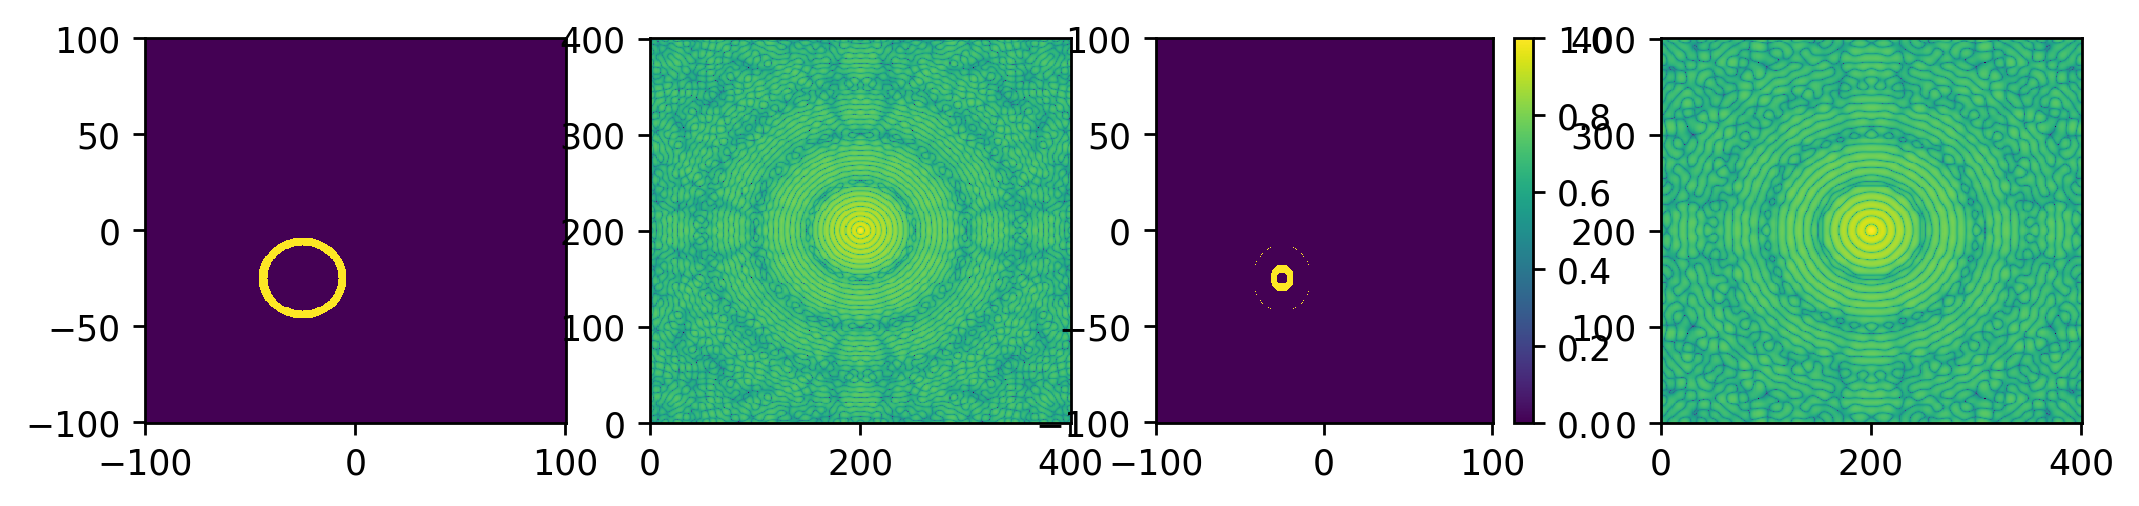

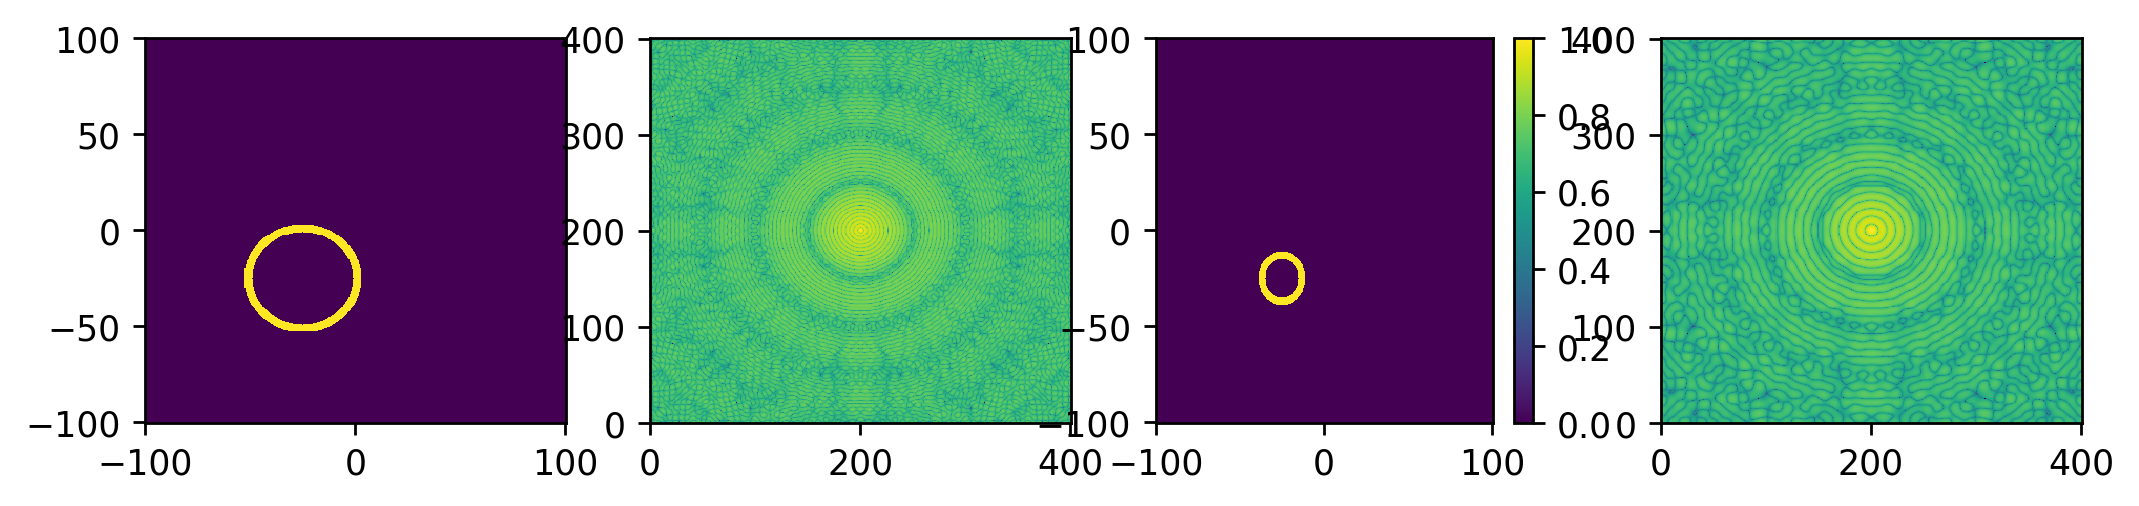

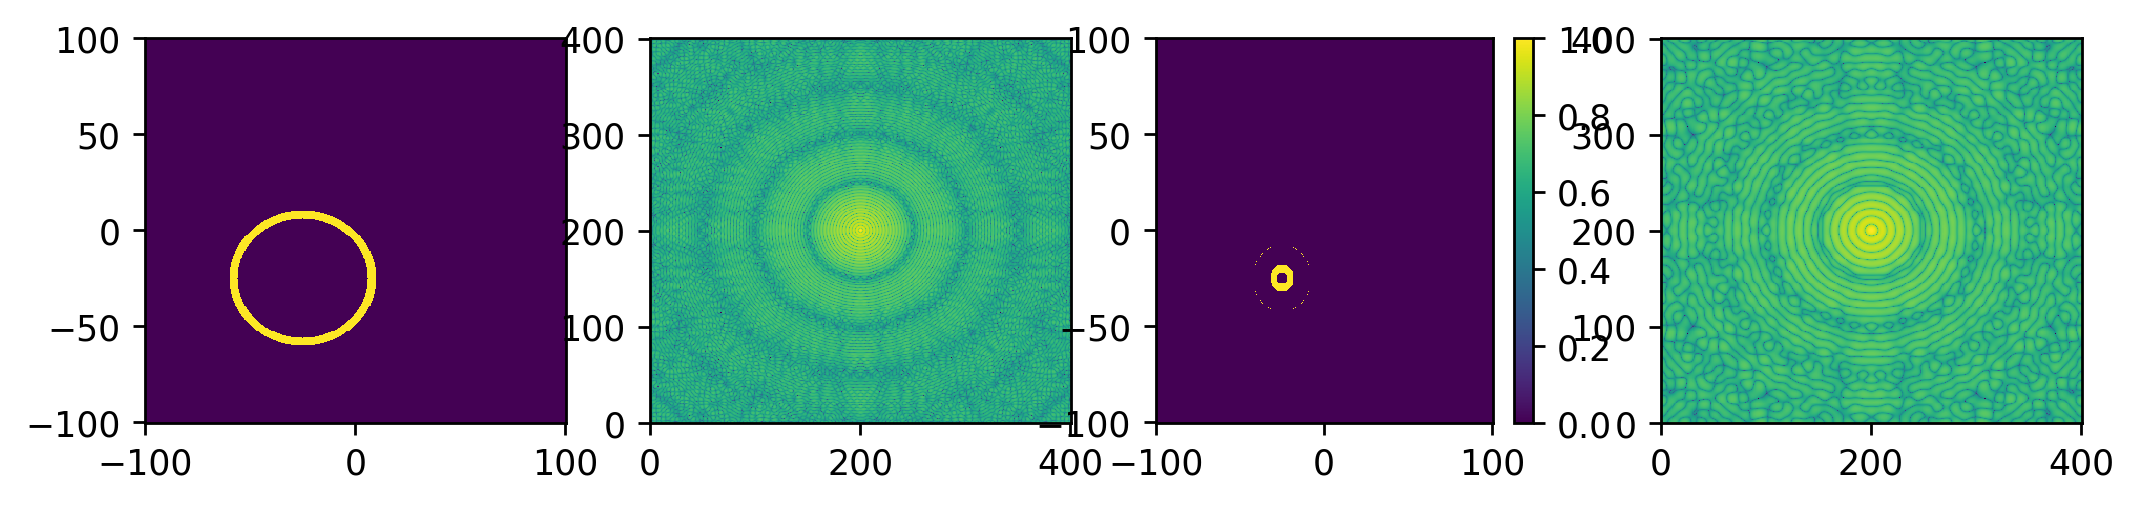

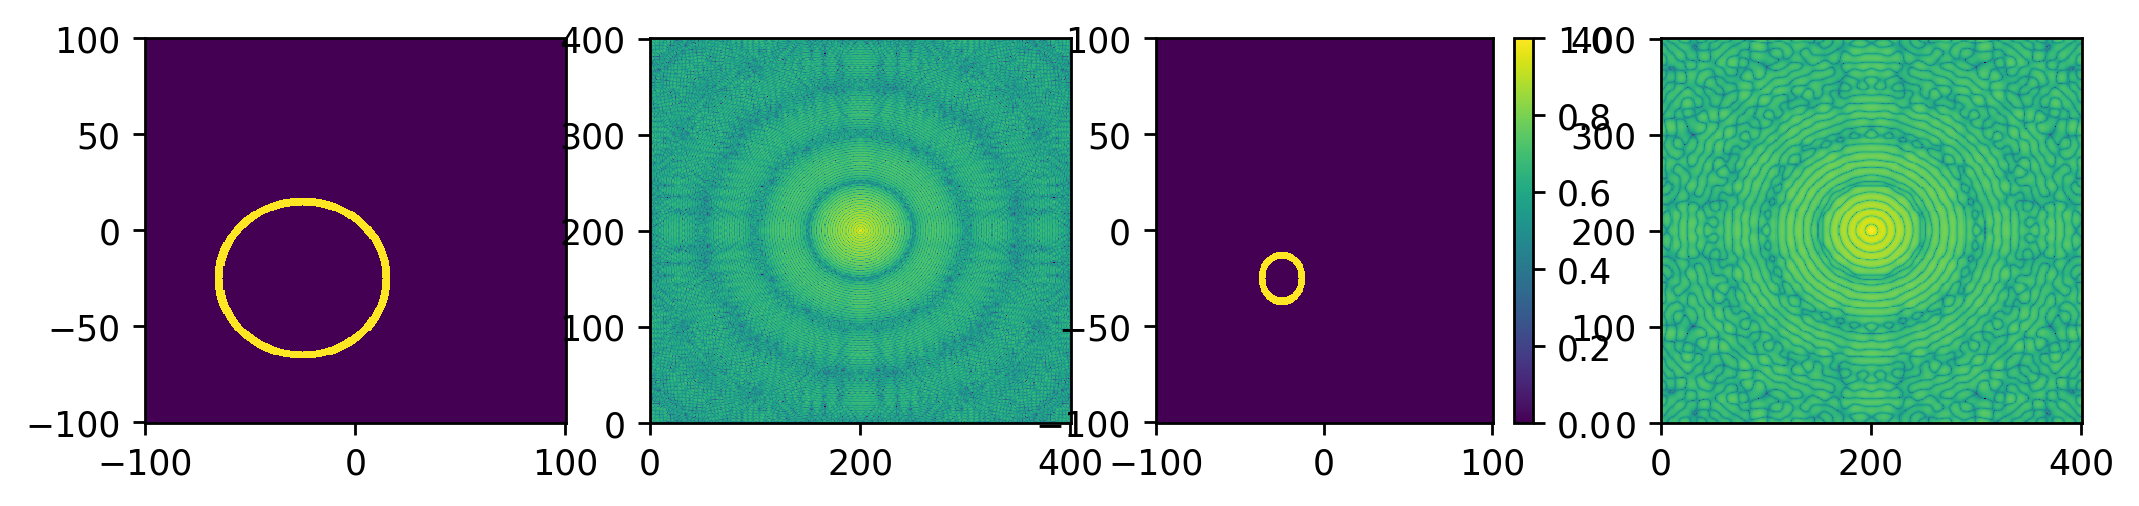

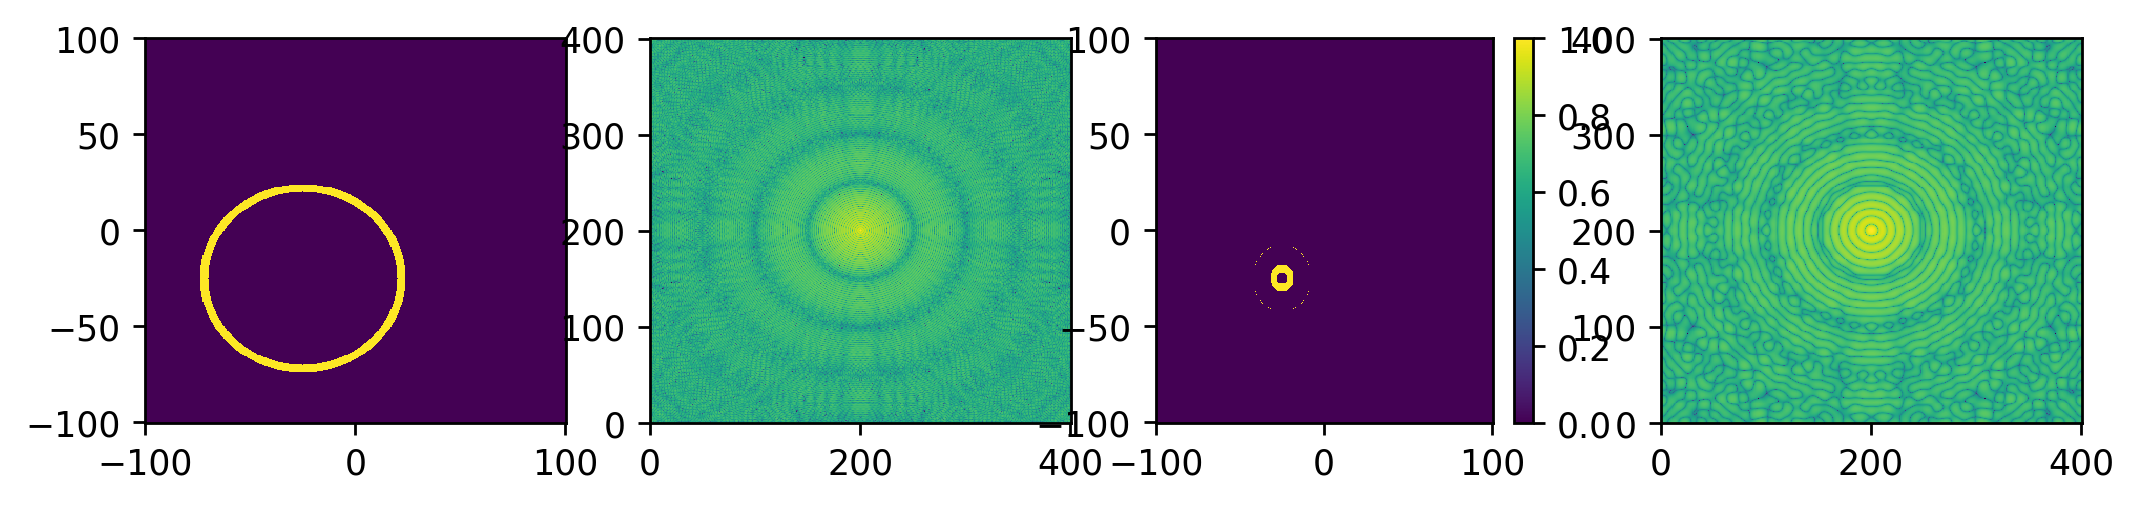

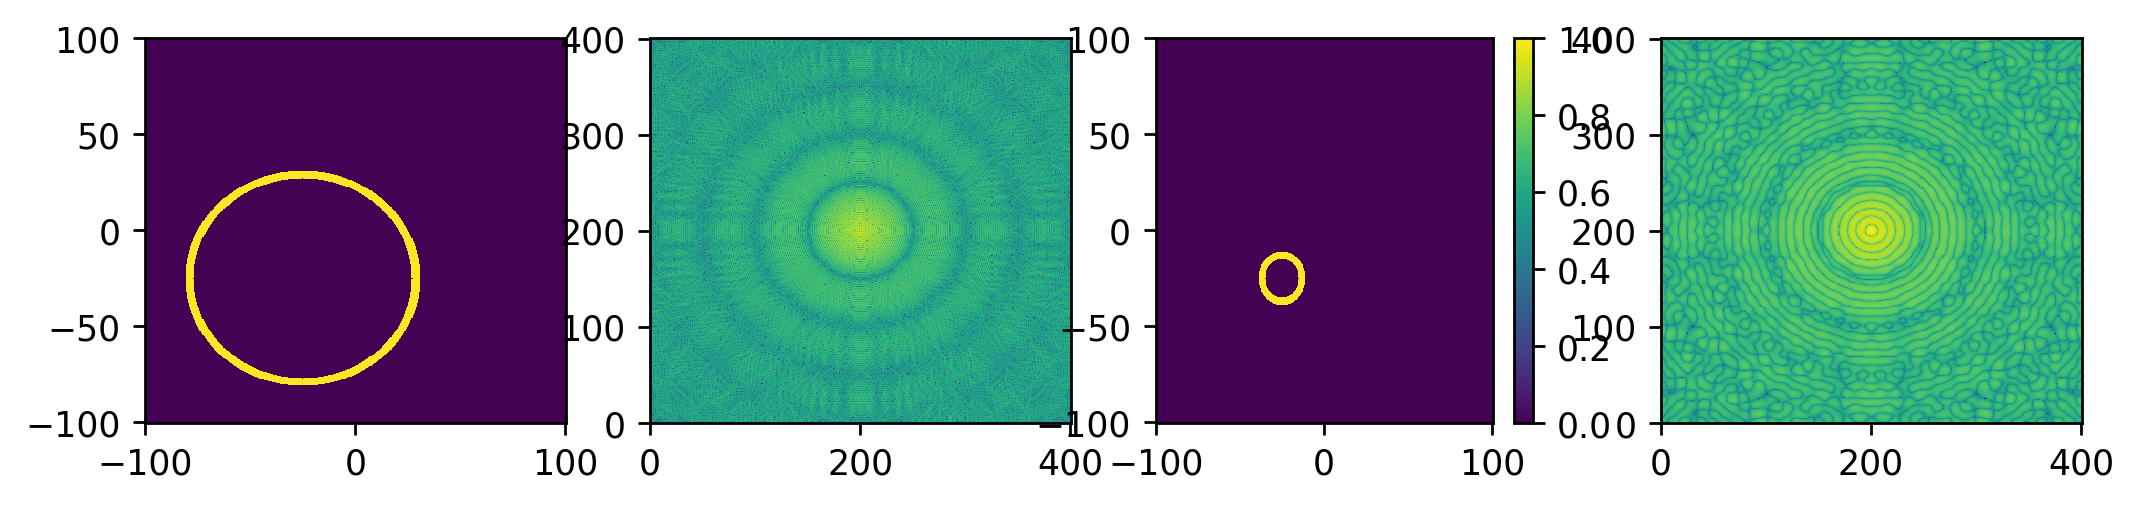

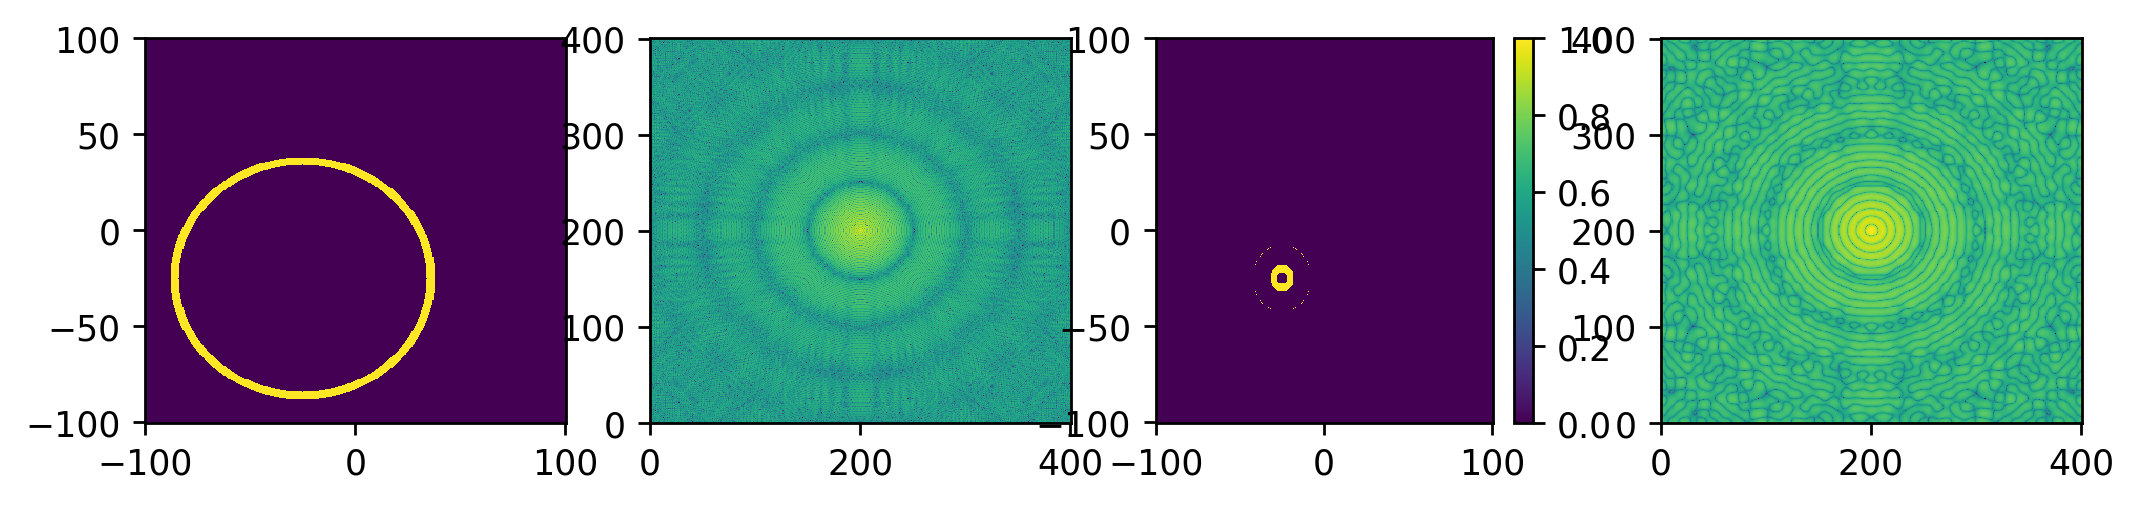

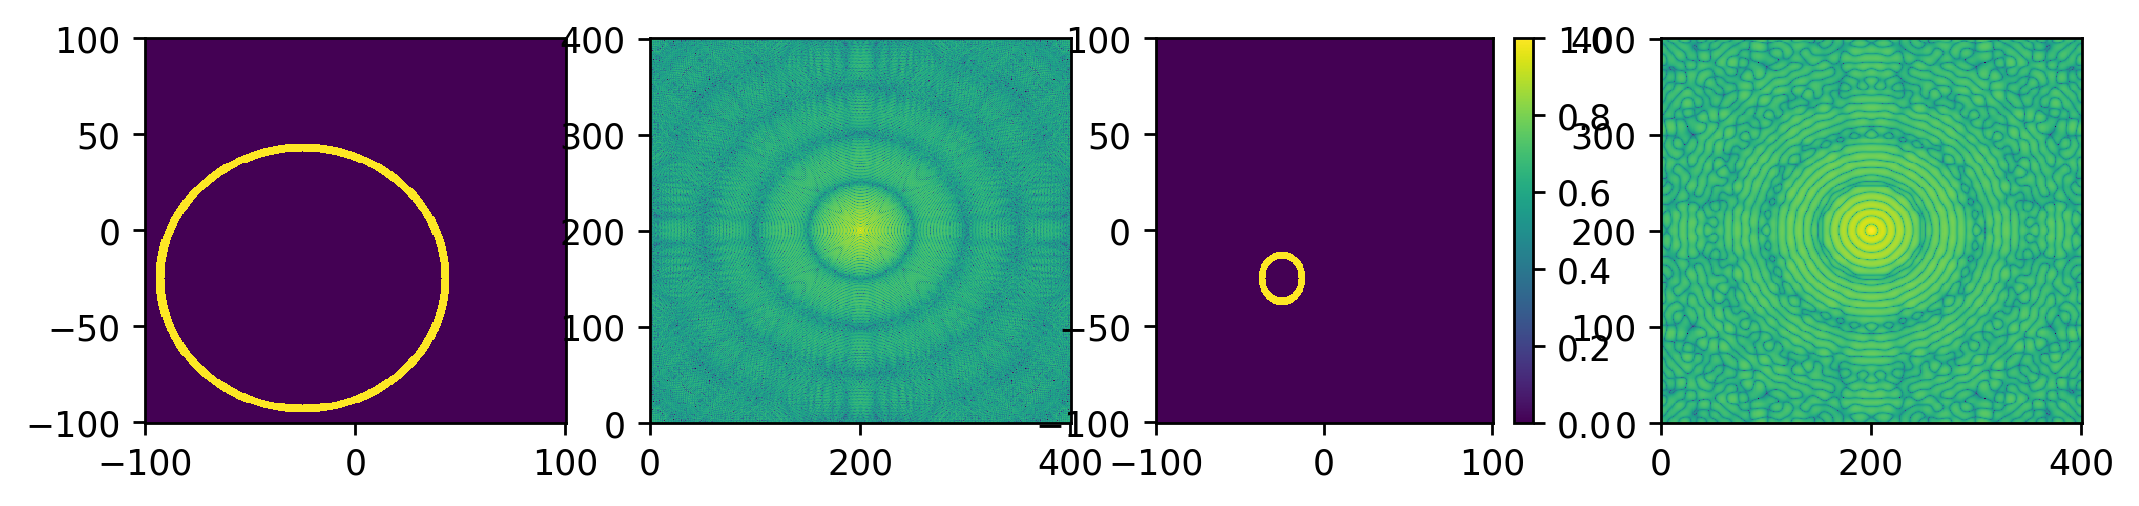

In [116]:
# fx=1
# fy=2
# vx=21
# vy=30
# dv = 0.1
S=[]
for t in range(2):
    buf=np.zeros(Cx.shape)
    buf[(np.abs(np.sqrt((Cx+25)**2+(Cy+25)**2)-(5+7*t)))<2]=1
    S.append(buf)
# P.append(S[0])
# P.append(S[1])
for t in range(2,10):
    # vx=21 + np.random.random(1)*dv
    # vy=30 + np.random.random(1)*dv
    buf=np.zeros(Cx.shape)
    buf[(np.abs(np.sqrt((Cx+25)**2+(Cy+25)**2)-(5+7*t)))<2]=1
    fig,ax=plt.subplots(1,4,figsize=(10, 2),dpi=250)
    # a=np.sin(2*np.pi*(fx/np.ptp(Cx)*(Cx+vx*t)+fy/np.ptp(Cy)*(Cy+vy*t)))
    ax[0].pcolormesh(Cx,Cy,buf)
    b=get_df(S[0],S[1],t-1)
    ax[1].pcolormesh(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(buf)))))
    pc=ax[2].pcolormesh(Cx,Cy,b>0.5)
    fig.colorbar(pc)
    ax[3].pcolormesh(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(b)))))
    # pc=ax[2].pcolormesh(np.abs(np.fft.fftshift(np.fft.fft(a))))
    # fig.colorbar(pc)
    

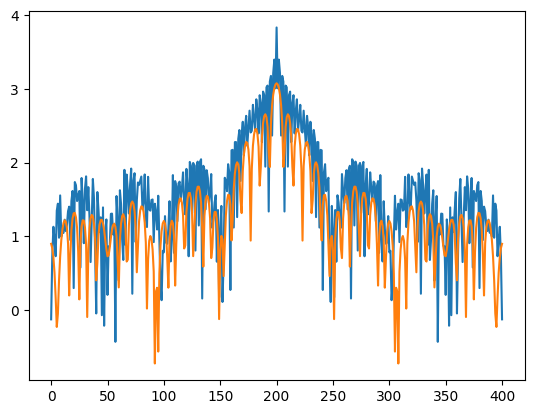

In [117]:
plt.plot(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(buf))))[buf.shape[0]//2,:])
plt.plot(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(b))))[b.shape[0]//2,:])